# CycleGAN for FER 
By Fatemeh Ghezloo and Michelle Lin

## Usage

The purpose of this notebook is to train a CycleGAN on the FER2013 Facial Expression Recognition dataset. There is also functionality included to save test images generated during training, produce loss plots for the generators and each of the discriminators, and generate data for a CNN.

To run this notebook, please make sure to first download the [FER2013 Kaggle dataset](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge). It would be easiest to put the `fer2013.csv` file into your Google Drive in the same location as where you want to save your model checkpoints and images. For reference, the folder structure we used was the following:

```
MyDrive/
└── colab_files/
|   └── final_project/
|   |   ├── fer2013.csv                       # FER2013 dataset
|   |   └── logs/
|   |   |   ├── 0.1/
|   |   |   ├── 0.2/
|   |   |   └── 0.3/                          # files for experiment 0.3
|   |   |   |   ├── <E>_generated.npy         # generated images from emotion <E> to add to CNN
|   |   |   |   ├── log.pkl                   # log file
|   |   |   |   ├── test_images_<N>/          # test images from epoch <N>
|   |   |   |   ├── images/                   # images generated during training
|   |   |   |   ├── D_A/                      # reference discriminator checkpoints
|   |   |   |   ├── D_B/                      # target discriminator checkpoints
|   |   |   |   ├── G_A2B/                    # reference -> target generator checkpoints
|   |   |   |   └── G_B2A/                    # target -> reference  generator checkpoints
```

This colab file should work regardless of folder structure, as long as you make sure the following file path variables point to the correct place:

* `BASE_PATH`: the base folder for your files in your Google Drive
* `LOG_PATH`: folder to save all training logs and images
* `TEST_PATH`: folder to save your test images from a specific epoch
* `OUTPUT_PATH`: folder to save your generated images for the CNN
* `GEN_A2B_PATH`: folder to save reference -> target model checkpoints
* `GEN_B2A_PATH`: folder to save target -> reference model checkpoints
* `DISC_A_PATH`: folder to save reference discriminator model checkpoints
* `DISC_B_PATH`: folder to save reference target model checkpoints

To train the model, you can simply select the ["Training the model" header](https://colab.research.google.com/drive/1woR0k_9zgc419iA_mFWuWLXsBl7DOSXy#scrollTo=UM37UOtypP-d) and run all cells above it (you can use Runtime > Run before). This will set up everything for training. Then, follow the instructions in the "Training the model" section to set your training parameters/constants and then you can train the CycleGAN.

Since loss is a usually a poor indicator of model correctness, the we can only test the model by simply displaying generated images from the test set ("PublicTest"). Since the test set can be quite large, we have also added saving functionality to our test function so that you can view the generated images along with the input in your Drive. Follow the instructions under the  ["Testing the model" section](https://colab.research.google.com/drive/1woR0k_9zgc419iA_mFWuWLXsBl7DOSXy#scrollTo=6MqnhJePpkpg&line=1&uniqifier=1) to generate and display test images.

If you would like to use your model to generate images for our CNN model, follow the instructions under the ["Generating images" section](https://colab.research.google.com/drive/1woR0k_9zgc419iA_mFWuWLXsBl7DOSXy#scrollTo=bKbijKJNAiF5).

Thanks for checking out our CycleGAN implementation! 

The majority of our code was implemented by us, but we referenced several Github repositories in the process:
* https://github.com/aitorzip/PyTorch-CycleGAN/
* https://github.com/junyanz/CycleGAN/
* https://github.com/FrancescoSaverioZuppichini/ResNet
* https://github.com/ivadym/FER/
* https://github.com/yunjey/mnist-svhn-transfer/


## Initial setup

Run the following sections to make sure that you are using the GPU, have imported all the necessary packages, can read from/write to your Google Drive, and have copied all data to the GPU. 

In [ ]:
import torch
print('Version', torch.__version__)
print('CUDA enabled:', torch.cuda.is_available())
  
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.0+cu101
CUDA enabled: True


In [ ]:
# Connect to your Google Drive
from google.colab import drive
drive.mount('/gdrive')
!ls /gdrive

Mounted at /gdrive
MyDrive  Shareddrives


In [ ]:
### Storage creation ###
import os
BASE_PATH = '/gdrive/My Drive/colab_files/final_project/'
if not os.path.exists(BASE_PATH):
    # Create a folder to store your generated images and checkpoints on your Drive
    os.makedirs(BASE_PATH)
DATA_PATH = '/content/'

# Download the data to the GPU so we can train the model
if not os.path.exists(os.path.join(DATA_PATH, 'fer2013.csv')):
    os.chdir(BASE_PATH) # Should be where fer2013.csv is stored in your Drive
    !cp fer2013.csv /content
    !ls
os.chdir('/content')

fer2013.csv  logs  pt_util.py


In [ ]:
### Imports ###

# Import necessary packages and functions
import torch
import torch.nn as nn
from torchvision import datasets
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.optim as optim
import sys
import pickle
import re
from torch.utils.data import DataLoader
from PIL import Image
import os
import multiprocessing
from torch.autograd import Variable
import csv
import h5py
from torchvision.utils import save_image
import itertools
from matplotlib import pyplot as plt
from __future__ import print_function
import random
import torch.utils.data as data
from torchvision import transforms
import glob

# Data preprocessing

In this section, we process the FER2013 CSV so that we can use the data later to train the CycleGAN. A dataset is created for each split (train, public test, and private test) and emotion (angry, disgust, fear, happy, sad, surprise, and neutral).

In [ ]:
### Data preparation and preprocessing ### 

# Variable definitions
emotionsToInd = {"Angry":0, "Disgust":1, "Fear":2, "Happy":3, "Sad":4, "Surprise":5, "Neutral":6}
indToEmotions = {emotionsToInd[key]:key for key in emotionsToInd}
setSizes = {"Training":[], "PublicTest":[], "PrivateTest":[]}

def prepare_data(data_path):
  # Creat the list to store the data and label information
  Training_x = {key:[] for key in indToEmotions}
  Training_y = {}
  PublicTest_x = {key:[] for key in indToEmotions}
  PublicTest_y = {}
  PrivateTest_x = {key:[] for key in indToEmotions}
  PrivateTest_y = {}

  datapath = os.path.join(DATA_PATH,'data.h5')
  if not os.path.exists(os.path.dirname(datapath)):
    os.makedirs(os.path.dirname(datapath))

  with open(data_path,'r') as csvin:
    data = csv.reader(csvin)
    for row in data:
      if row[-1] == 'Training':
        temp_list = []
        for pixel in row[1].split( ):
          temp_list.append(int(pixel))
        I = np.asarray(temp_list)
        Training_x[int(row[0])].append(I.tolist())

      if row[-1] == "PublicTest" :
        temp_list = []
        for pixel in row[1].split( ):
          temp_list.append(int(pixel))
        I = np.asarray(temp_list)
        PublicTest_x[int(row[0])].append(I.tolist())

      if row[-1] == 'PrivateTest':
        temp_list = []
        for pixel in row[1].split( ):
          temp_list.append(int(pixel))
        I = np.asarray(temp_list)
        PrivateTest_x[int(row[0])].append(I.tolist())

  for key in emotionsToInd:
    setSizes["Training"].append(np.shape(Training_x[emotionsToInd[key]])[0])
    print(key, "training data:", np.shape(Training_x[emotionsToInd[key]]))
    setSizes["PublicTest"].append(np.shape(PublicTest_x[emotionsToInd[key]])[0])
    print(key, "public test data:", np.shape(PublicTest_x[emotionsToInd[key]]))
    setSizes["PrivateTest"].append(np.shape(PrivateTest_x[emotionsToInd[key]])[0])
    print(key, "private test data:", np.shape(PrivateTest_x[emotionsToInd[key]]), "\n")

  print(setSizes)

  datafile = h5py.File(datapath, 'w')
  print("Start to construct data file...")
  for key in emotionsToInd:
    datafile.create_dataset("Training_pixel_" + key, dtype = 'uint8', data=Training_x[emotionsToInd[key]])
    datafile.create_dataset("PublicTest_pixel_" + key, dtype = 'uint8', data=PublicTest_x[emotionsToInd[key]])
    datafile.create_dataset("PrivateTest_pixel_" + key, dtype = 'uint8', data=PrivateTest_x[emotionsToInd[key]])
    print("Finish data file creation for", key)
  datafile.close()

  print("Save data finished.")

prepare_data(DATA_PATH + 'fer2013.csv')

Angry training data: (3995, 2304)
Angry public test data: (467, 2304)
Angry private test data: (491, 2304) 

Disgust training data: (436, 2304)
Disgust public test data: (56, 2304)
Disgust private test data: (55, 2304) 

Fear training data: (4097, 2304)
Fear public test data: (496, 2304)
Fear private test data: (528, 2304) 

Happy training data: (7215, 2304)
Happy public test data: (895, 2304)
Happy private test data: (879, 2304) 

Sad training data: (4830, 2304)
Sad public test data: (653, 2304)
Sad private test data: (594, 2304) 

Surprise training data: (3171, 2304)
Surprise public test data: (415, 2304)
Surprise private test data: (416, 2304) 

Neutral training data: (4965, 2304)
Neutral public test data: (607, 2304)
Neutral private test data: (626, 2304) 

{'Training': [3995, 436, 4097, 7215, 4830, 3171, 4965], 'PublicTest': [467, 56, 496, 895, 653, 415, 607], 'PrivateTest': [491, 55, 528, 879, 594, 416, 626]}
Start to construct data file...
Finish data file creation for Angry
Fin

# Helper functions

Below are some useful helper functions. In the first section are functions to help with model checkpointing and plotting. The second section contains functions to work with images. 

## pt_util

The functions below help with saving/loading the model, plotting loss/accuracy plots, and reading to/writing from the log file. 

In [ ]:
# These helper functions are copied from pt_util file by https://github.com/pjreddie/

try:
    # For 2.7
    import cPickle as pickle
except:
    # For 3.x
    import pickle

def restore(net, save_file):
    """Restores the weights from a saved file

    This does more than the simple Pytorch restore. It checks that the names
    of variables match, and if they don't doesn't throw a fit. It is similar
    to how Caffe acts. This is especially useful if you decide to change your
    network architecture but don't want to retrain from scratch.

    Args:
        net(torch.nn.Module): The net to restore
        save_file(str): The file path
    """

    net_state_dict = net.state_dict()
    restore_state_dict = torch.load(save_file)

    restored_var_names = set()

    print('Restoring:')
    for var_name in restore_state_dict.keys():
        if var_name in net_state_dict:
            var_size = net_state_dict[var_name].size()
            restore_size = restore_state_dict[var_name].size()
            if var_size != restore_size:
                print('Shape mismatch for var', var_name, 'expected', var_size, 'got', restore_size)
            else:
                if isinstance(net_state_dict[var_name], torch.nn.Parameter):
                    # backwards compatibility for serialized parameters
                    net_state_dict[var_name] = restore_state_dict[var_name].data
                try:
                    net_state_dict[var_name].copy_(restore_state_dict[var_name])
                    print(str(var_name) + ' -> \t' + str(var_size) + ' = ' + str(int(np.prod(var_size) * 4 / 10**6)) + 'MB')
                    restored_var_names.add(var_name)
                except Exception as ex:
                    print('While copying the parameter named {}, whose dimensions in the model are'
                          ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                              var_name, var_size, restore_size))
                    raise ex

    ignored_var_names = sorted(list(set(restore_state_dict.keys()) - restored_var_names))
    unset_var_names = sorted(list(set(net_state_dict.keys()) - restored_var_names))
    print('')
    if len(ignored_var_names) == 0:
        print('Restored all variables')
    else:
        print('Did not restore:\n\t' + '\n\t'.join(ignored_var_names))
    if len(unset_var_names) == 0:
        print('No new variables')
    else:
        print('Initialized but did not modify:\n\t' + '\n\t'.join(unset_var_names))

    print('Restored %s' % save_file)


def restore_latest(net, folder):
    """Restores the most recent weights in a folder

    Args:
        net(torch.nn.module): The net to restore
        folder(str): The folder path
    Returns:
        int: Attempts to parse the epoch from the state and returns it if possible. Otherwise returns 0.
    """

    checkpoints = sorted(glob.glob(folder + '/*.pt'), key=os.path.getmtime)
    start_it = 0
    if len(checkpoints) > 0:
        restore(net, checkpoints[-1])
        try:
            start_it = int(re.findall(r'\d+', checkpoints[-1])[-1])
        except:
            pass
    return start_it


def save(net, file_name, num_to_keep=1):
    """Saves the net to file, creating folder paths if necessary.

    Args:
        net(torch.nn.module): The network to save
        file_name(str): the path to save the file.
        num_to_keep(int): Specifies how many previous saved states to keep once this one has been saved.
            Defaults to 1. Specifying < 0 will not remove any previous saves.
    """

    folder = os.path.dirname(file_name)
    if not os.path.exists(folder):
        os.makedirs(folder)
    torch.save(net.state_dict(), file_name)
    extension = os.path.splitext(file_name)[1]
    checkpoints = sorted(glob.glob(folder + '/*' + extension), key=os.path.getmtime)
    print('Saved %s\n' % file_name)
    if num_to_keep > 0:
        for ff in checkpoints[:-num_to_keep]:
            os.remove(ff)

def write_log(filename, data):
    """Pickles and writes data to a file

    Args:
        filename(str): File name
        data(pickleable object): Data to save
    """

    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    pickle.dump(data, open(filename, 'wb'))

def read_log(filename, default_value=None):
    """Reads pickled data or returns the default value if none found

    Args:
        filename(str): File name
        default_value(anything): Value to return if no file is found
    Returns:
        unpickled file
    """

    if os.path.exists(filename):
        return pickle.load(open(filename, 'rb'))
    return default_value

def show_images(images, titles=None, columns=5, max_rows=5):
    """Shows images in a tiled format

    Args:
        images(list[np.array]): Images to show
        titles(list[string]): Titles for each of the images
        columns(int): How many columns to use in the tiling
        max_rows(int): If there are more than columns * max_rows images, only the first n of them will be shown.
    """

    images = images[:min(len(images), max_rows * columns)]

    plt.figure(figsize=(20, 10))
    for ii, image in enumerate(images):
        plt.subplot(len(images) / columns + 1, columns, ii + 1)
        plt.axis('off')
        if titles is not None and ii < len(titles):
            plt.title(str(titles[ii]))
        plt.imshow(image)
    plt.show()

def plot(x_values, y_values, title, xlabel, ylabel):
    """Plots a line graph

    Args:
        x_values(list or np.array): x values for the line
        y_values(list or np.array): y values for the line
        title(str): Title for the plot
        xlabel(str): Label for the x axis
        ylabel(str): label for the y axis
    """

    plt.figure(figsize=(20, 10))
    plt.plot(x_values, y_values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def to_scaled_uint8(array):
    """Returns a normalized uint8 scaled to 0-255. This is useful for showing images especially of floats.

    Args:
        array(np.array): The array to normalize
    Returns:
        np.array normalized and of type uint8
    """

    array = np.array(array, dtype=np.float32)
    array -= np.min(array)
    array *= (255. / np.max(array))
    array = array.astype(np.uint8)
    return array

## Working with images

The `_pixels_to_image` function will convert pixel values to an image, which is needed to display the image on the console. The `_save_and_display_image` function will display a given image and also save it to your desired location (usually in your Google Drive) so that it can be accessed even after the output for this notebook is overwritten.

In [ ]:
def _pixels_to_image(pixels, transform=None):
  """
  Converts a matrix of pixels into a PIL image
  Args:
    pixels (matrix of ints): Pixel values
  Returns:
    A PIL Image representing the given pixels
  """    
  img = pixels[:, :, np.newaxis]
  img = np.concatenate((img, img, img), axis=2)
  img = Image.fromarray(img.astype(np.uint8))
  if transform is not None:
    img = transform(img)
  return img

def _save_and_display_image(pixels, display_name, file_path, file_name):
  """
  Displays and saves the given image
  Args:
    pixels (matrix of ints): Pixel values
    display_name (string): name to display on console along with image
    file_path (string): where the image should be stored
    file_name (string): what the image file should be called
  """
  print("%s:" % display_name)
  display(_pixels_to_image(pixels))
  save_image(pixels, file_path + file_name, normalize=True)

# Loading the data

FER data retreived from https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data

In [ ]:
### Dataset declaration and definition ### 
class FER2013(data.Dataset):
  ''' Fer2013 Dataset class'''
  def __init__(self, classA="Neutral", classB="Disgust", split='Training', transforms_=None, unaligned=True):
    self.transform = transforms.Compose(transforms_) if transforms_ is not None else None
    self.split = split  # training set or test set
    self.data = h5py.File(DATA_PATH + 'data.h5', 'r', driver='core')
    self.classA = classA
    self.classB = classB
    self.unaligned = unaligned

    self.train_data_full = {self.classA:[], self.classB:[]}
    self.PublicTest_data_full = {self.classA:[], self.classB:[]}
    self.PrivateTest_data_full = {self.classA:[], self.classB:[]}

    if self.split == 'Training':
      self.train_data_A = self._reshape_data(self.classA, 'Training_pixel_' + self.classA)
      self.train_data_B = self._reshape_data(self.classB, 'Training_pixel_' + self.classB)

    elif self.split == 'PublicTest':
      self.PublicTest_data_A = self._reshape_data(self.classA, 'PublicTest_pixel_' + self.classA)
      self.PublicTest_data_B = self._reshape_data(self.classB, 'PublicTest_pixel_' + self.classB)

    else:
      self.PrivateTest_data_A = self._reshape_data(self.classA, 'PrivateTest_pixel_' + self.classA)
      self.PrivateTest_data_B = self._reshape_data(self.classB, 'PrivateTest_pixel_' + self.classB)

  def _reshape_data(self, key, dataset_name):
    data = self.data[dataset_name]
    data = np.asarray(data)
    return data.reshape((setSizes[self.split][emotionsToInd[key]], 48, 48))

  def __getitem__(self, index):
    """
    Args:
      index (int): Index
    Returns:
      tuple: (image, target) where target is index of the target class.
    """    
    if self.split == 'Training':
      item_A, item_B = self._get_image_item(index, self.train_data_A, self.train_data_B)
    elif self.split == 'PublicTest':
      item_A, item_B = self._get_image_item(index, self.PublicTest_data_A, self.PublicTest_data_B)
    else:
      item_A, item_B = self._get_image_item(index, self.PrivateTest_data_A, self.PrivateTest_data_B)
    return {'A': item_A, 'B': item_B}

  def _get_image_item(self, index, data_A, data_B):
    """
    Gets an item from each dataset but in image form
    Args:
      index (int): Index
      data_A (list): list of pixels from class A
      data_B (list): list of pixels from class B
    Returns:
      Dictionary containing a pair of images from class A and class B.
    """    
    item_A = data_A[index % len(data_A)]
    if self.unaligned:
      item_B = data_B[random.randint(0, len(data_B) - 1)]
    else:
      item_B = data_B[index % len(data_B)]
    if self.transform is not None:
      item_A = self.transform(torch.Tensor(item_A))
      item_B = self.transform(torch.Tensor(item_B))
    return item_A, item_B

  def __len__(self):
    if self.split == 'Training':
      return max(len(self.train_data_A), len(self.train_data_B))
    elif self.split == 'PublicTest':
      return max(len(self.PublicTest_data_A), len(self.PublicTest_data_B))
    else:
      return max(len(self.PrivateTest_data_A), len(self.PrivateTest_data_B))

# Defining the network

In this section we define the classes for our network and functions to train/test our model. The model architecture was largely modeled off of the [Emotion Classification with Data AugmentationUsing Generative Adversarial Networks paper by Zhu et. al.](https://arxiv.org/pdf/1711.00648.pdf), but we made some modifications. We removed the normalization at output layers for both the generator and discriminator, replaced most other batch normalization layers with instance norm because the reported batch size was 1, and added padding as needed so that output dimensions were what we expected.

Feel free to play around with the architecture! Some ideas might be trying different types of normalization layers, activations, kernel sizes, or strides.

## Resnet class

Class for a single Resnet block as defined in the Resnet paper

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [  nn.Conv2d(in_features, in_features, 3, padding=1),
                        nn.BatchNorm2d(in_features),
                        nn.ReLU(inplace=True),
                        nn.Conv2d(in_features, in_features, 3, padding=1),
                        nn.BatchNorm2d(in_features)  ]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

## Generator class

In [ ]:
class Generator(nn.Module):
    """
    Generator class

    Args:
      input_nc (int): number of input channels
      output_nc (int): number of output channels
      n_residual_blocks (int): number of residual blocks
    """
    def __init__(self, input_nc=3, output_nc=3, n_residual_blocks=6):
        super(Generator, self).__init__()

        # Initial convolution block       
        model = [   nn.Conv2d(input_nc, 64, 7, padding=3, stride=1),
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [  nn.Conv2d(in_features, out_features, 3, padding=1, stride=2), 
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [  nn.ConvTranspose2d(in_features, out_features, 3, padding=1, output_padding=1, stride=2), # not sure if stride is 0.5 or if we need padding
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [ nn.Conv2d(64, output_nc, 7, padding=3) ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)
    
    def save_model(self, file_path, num_to_keep=1):
        save(self, file_path, num_to_keep)

    def load_last_model(self, dir_path):
        return restore_latest(self, dir_path)


## Discriminator class

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_nc=3):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [   nn.Conv2d(input_nc, 64, 4, stride=2), 
                    nn.InstanceNorm2d(64),
                    nn.ReLU(inplace=True) ]
        
        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(3):
            model += [  nn.Conv2d(in_features, out_features, 4, stride=2, padding=2),
                        nn.InstanceNorm2d(out_features),
                        nn.ReLU(inplace=True) ]
            in_features = out_features
            out_features = in_features * 2

        # Output layer
        model += [ nn.Conv2d(512, 1, 4) ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x).view(1)

    def save_model(self, file_path, num_to_keep=1):
        save(self, file_path, num_to_keep)
        
    def load_last_model(self, dir_path):
        return restore_latest(self, dir_path)

## Replay Buffer class

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

## Weight initialization function

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Train and test functions

These functions each run one epoch of the training and testing. 

In [ ]:
### Train and Test fuctions ###

def train(dataloader, epoch, log_interval, lambda1, lambda2,
          netG_A2B, netG_B2A, netD_A, netD_B,
          optimizer_G, optimizer_D_A, optimizer_D_B,
          criterion_identity, criterion_GAN, criterion_cycle,
          input_A, input_B, fake_A_buffer, fake_B_buffer,
          target_real, target_fake, d_interval):
  netG_A2B.train()
  netG_B2A.train()
  netD_A.train()
  netD_B.train()

  losses_G = []
  losses_D_A = []
  losses_D_B = []

  for batch_idx, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()

    # GAN loss
    fake_B = netG_A2B(real_A)
    pred_fake = netD_B(fake_B)
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

    fake_A = netG_B2A(real_B)
    pred_fake = netD_A(fake_A)
    # print(pred_fake)
    loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

    # Cycle loss
    recovered_A = netG_B2A(fake_B)
    loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*lambda1

    recovered_B = netG_A2B(fake_A)
    loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*lambda2

    # Total loss
    loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
    losses_G.append(loss_G.item())
    loss_G.backward()
    
    optimizer_G.step()
    ###################################

    ###### Discriminator A ######
    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(real_A)
    loss_D_real = criterion_GAN(pred_real, target_real)

    # Fake loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake = netD_A(fake_A.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_A = (loss_D_real + loss_D_fake)
    losses_D_A.append(loss_D_A.item())
    if epoch % d_interval == 0:
      loss_D_A.backward()

    optimizer_D_A.step()
    ###################################

    ###### Discriminator B ######
    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(real_B)
    loss_D_real = criterion_GAN(pred_real, target_real)
    
    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake = netD_B(fake_B.detach())
    loss_D_fake = criterion_GAN(pred_fake, target_fake)

    # Total loss
    loss_D_B = (loss_D_real + loss_D_fake)
    losses_D_B.append(loss_D_B.item())
    if epoch % d_interval == 0:
      loss_D_B.backward()

    optimizer_D_B.step()
    ###################################

    if batch_idx % log_interval == 0:
      print("\nEpoch", epoch, ": Batch number", batch_idx)
      print("generator train loss (total)", loss_G.item())
      print("discriminator A's train loss (total)", loss_D_A.item())
      print("discriminator B's train loss (total)", loss_D_B.item())
  return np.mean(losses_G), np.mean(losses_D_A), np.mean(losses_D_B)

def test(testloader, epoch, reference_class, target_class, 
         netG_A2B, netG_B2A, input_A, input_B, 
         log_interval=None, log_path=DATA_PATH):
  netG_A2B.eval()
  netG_B2A.eval()

  with torch.no_grad():
    for batch_idx, batch in enumerate(testloader):
      # Set model input
      real_A = Variable(input_A.copy_(batch['A']))
      real_B = Variable(input_B.copy_(batch['B']))

      # Generate output 
      fake_B = netG_A2B(real_A).data
      fake_A = netG_B2A(real_B).data

      if log_interval is not None and batch_idx % log_interval == 0:
        print("Epoch", epoch, ": Batch number", batch_idx)
        _save_and_display_image(real_A[0][0].cpu(), "Real " + reference_class, log_path, 'real_%s_%03d_%03d.png' % (reference_class, epoch, batch_idx))
        _save_and_display_image(real_B[0][0].cpu(), "Real " + target_class, log_path, 'real_%s_%03d_%03d.png' % (target_class, epoch, batch_idx))
        _save_and_display_image(fake_A[0][0].cpu(), "Fake " + reference_class, log_path, 'fake_%s_%03d_%03d.png' % (reference_class, epoch, batch_idx))
        _save_and_display_image(fake_B[0][0].cpu(), "Fake " + target_class, log_path, 'fake_%s_%03d_%03d.png' % (target_class, epoch, batch_idx))

# Training the model

Run the following cell to train your CycleGAN model. Before running, make sure that your reference class, target class, and hyperparameters are what you want them to be. If you want to continue training a model, set `EXPERIMENT_VERSION` to a number you have used previously. Otherwise, make sure to change `EXPEIRMENT_VERSION` to avoid reading/overwriting previous model information.

Feel free to experiment with different hyperparameters to see how it affects training!

Resuming at epoch 0

Epoch 0 : Batch number 0
generator train loss (total) 1700.6256103515625
discriminator A's train loss (total) 6.632560729980469
discriminator B's train loss (total) 1.3292224407196045

Epoch 0 : Batch number 500
generator train loss (total) 970.384521484375
discriminator A's train loss (total) 10.297931671142578
discriminator B's train loss (total) 1.5095298290252686

Epoch 0 : Batch number 1000
generator train loss (total) 1151.8692626953125
discriminator A's train loss (total) 4.677032470703125
discriminator B's train loss (total) 0.32039156556129456

Epoch 0 : Batch number 1500
generator train loss (total) 628.6248168945312
discriminator A's train loss (total) 1.0699831247329712
discriminator B's train loss (total) 0.5451933741569519

Epoch 0 : Batch number 2000
generator train loss (total) 713.375244140625
discriminator A's train loss (total) 0.21745958924293518
discriminator B's train loss (total) 0.39720413088798523

Epoch 0 : Batch number 2500
generator trai

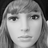

Real Disgust :


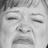

Fake Neutral :


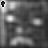

Fake Disgust :


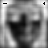

Epoch 0 : Batch number 501
Real Neutral :


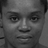

Real Disgust :


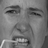

Fake Neutral :


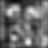

Fake Disgust :


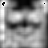

Writing log...
Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/G_A2B/000.pt

Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/G_B2A/000.pt

Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/D_A/000.pt

Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/D_B/000.pt


Epoch 1 : Batch number 0
generator train loss (total) 492.70654296875
discriminator A's train loss (total) 0.03367992118000984
discriminator B's train loss (total) 0.1773274540901184
Interrupted
Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/G_A2B/001.pt

Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/G_B2A/001.pt

Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/D_A/001.pt

Saved /gdrive/My Drive/colab_files/final_project/logs/0.13/D_B/001.pt



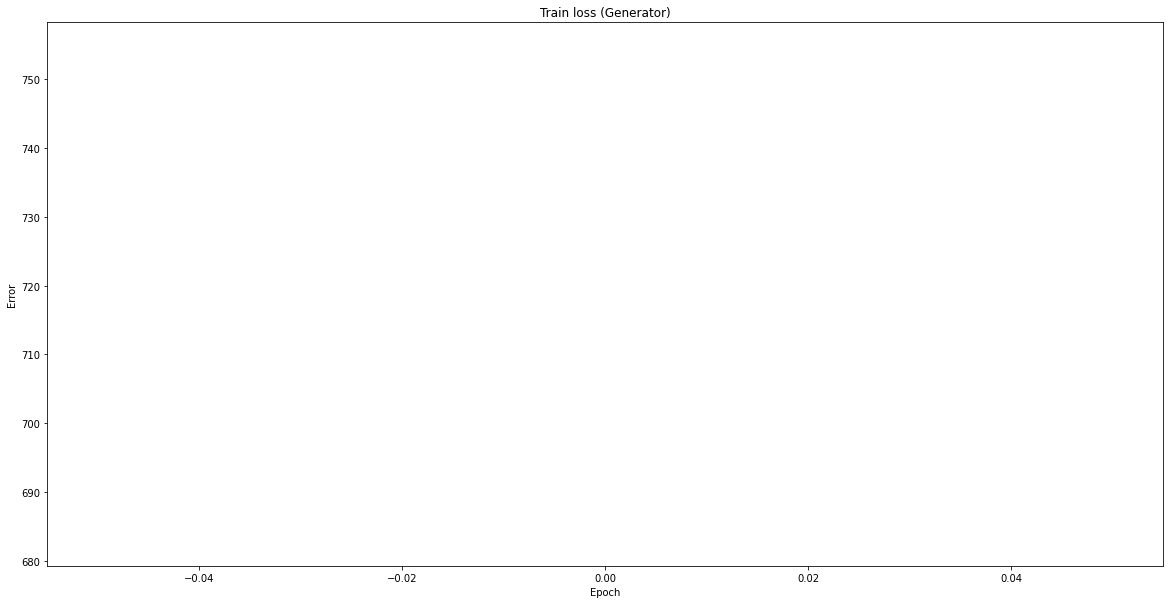

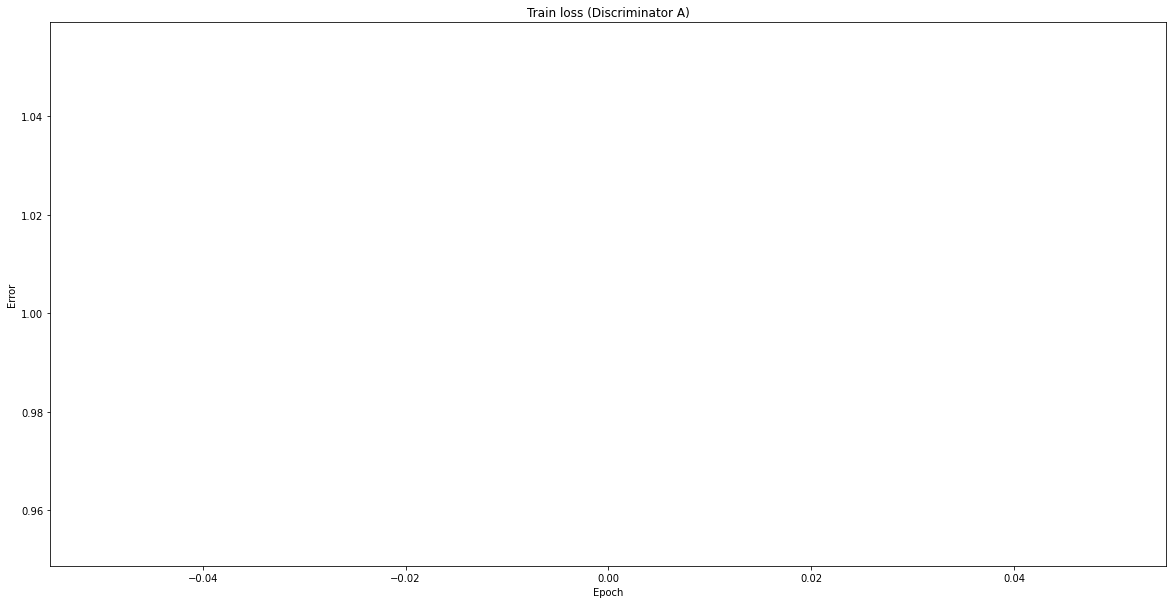

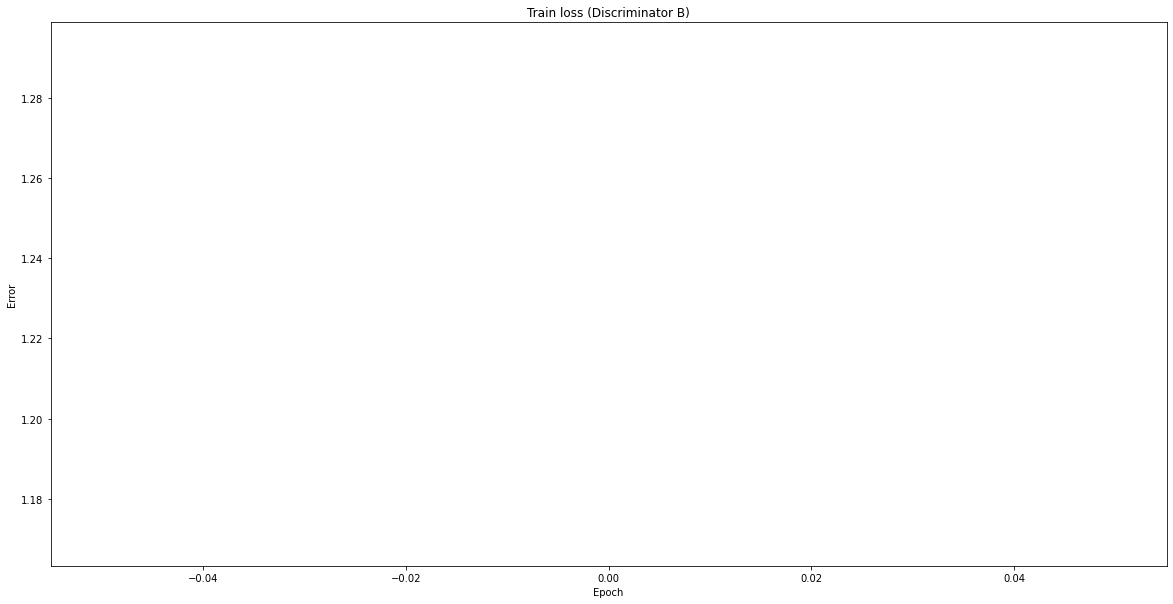

In [ ]:
###### Definition of variables ######
GEN_A2B_PATH = "G_A2B/" # Where the reference -> target model checkpoints are saved
GEN_B2A_PATH = "G_B2A/" # Where the target -> reference model checkpoints are saved
DISC_A_PATH = "D_A/" # Where the reference class discriminator model checkpoints are saved
DISC_B_PATH = "D_B/" # Where the target class discriminator model checkpoints are saved

REFERENCE_CLASS = "Neutral"
TARGET_CLASS = "Disgust"

# Hyperparameters
BATCH_SIZE = 1 
IMAGE_SIZE = 48
INPUT_CHANNELS = 1
OUTPUT_CHANNELS = 1
EPOCHS = 5
LEARNING_RATE = 0.0002
PRINT_INTERVAL = 500
BETA_1 = 0.5
LAMBDA_1 = 10.0
LAMBDA_2 = 10.0
D_INTERVAL = 5 # Interval for discriminator training

EXPERIMENT_VERSION = "0.13" # increment this to start a new experiment
LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

USE_CUDA = True
num_workers = multiprocessing.cpu_count()
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")

# Networks
netG_A2B = Generator(input_nc=INPUT_CHANNELS, output_nc=OUTPUT_CHANNELS)
netG_B2A = Generator(input_nc=OUTPUT_CHANNELS, output_nc=INPUT_CHANNELS)
netD_A = Discriminator(input_nc=INPUT_CHANNELS)
netD_B = Discriminator(input_nc=OUTPUT_CHANNELS)

netG_A2B.to(device)
netG_B2A.to(device)
netD_A.to(device)
netD_B.to(device)

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()

# Optimizers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=LEARNING_RATE, betas=(BETA_1, 0.999))

# Inputs & targets memory allocation
input_A = torch.Tensor(BATCH_SIZE, INPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)
input_B = torch.Tensor(BATCH_SIZE, OUTPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)
target_real = Variable(torch.Tensor(BATCH_SIZE).fill_(1.0), requires_grad=False).to(device)
target_fake = Variable(torch.Tensor(BATCH_SIZE).fill_(0.0), requires_grad=False).to(device)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_train = [ transforms.RandomHorizontalFlip() ]
transforms_test = None
dataloader = DataLoader(FER2013(classA=REFERENCE_CLASS, classB=TARGET_CLASS, transforms_=transforms_train, unaligned=True), batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
testloader = DataLoader(FER2013(classA=REFERENCE_CLASS, classB=TARGET_CLASS, split='PublicTest', transforms_=transforms_test, unaligned=True), batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
###################################

if not os.path.exists(LOG_PATH + 'images/'):
    os.makedirs(LOG_PATH + 'images/')

train_losses_G, train_losses_D_A, train_losses_D_B, test_losses_G, test_losses_D_A, test_losses_D_B = read_log(LOG_PATH + 'log.pkl', ([], [], [], [], [], []))

# Start at last checkpoint
start_epoch = min([netG_A2B.load_last_model(LOG_PATH + GEN_A2B_PATH),
                   netG_B2A.load_last_model(LOG_PATH + GEN_B2A_PATH),
                   netD_A.load_last_model(LOG_PATH + DISC_A_PATH),
                   netD_B.load_last_model(LOG_PATH + DISC_B_PATH)])

print("Resuming at epoch", start_epoch)


try:
  for epoch in range(start_epoch, EPOCHS + 1):
    train_loss_G, train_loss_D_A, train_loss_D_B = train(dataloader, epoch, PRINT_INTERVAL, LAMBDA_1, LAMBDA_2, 
                                                         netG_A2B, netG_B2A, netD_A, netD_B, 
                                                         optimizer_G, optimizer_D_A, optimizer_D_B, 
                                                         criterion_identity, criterion_GAN, criterion_cycle, 
                                                         input_A, input_B, fake_A_buffer, fake_B_buffer, 
                                                         target_real, target_fake, D_INTERVAL)
    test(testloader, epoch, REFERENCE_CLASS, TARGET_CLASS, netG_A2B, netG_B2A, input_A, input_B, 
         log_interval=PRINT_INTERVAL, log_path=(LOG_PATH + "images/"))

    # Keep track of losses over many epochs
    train_losses_G.append((epoch, train_loss_G))
    train_losses_D_A.append((epoch, train_loss_D_A))
    train_losses_D_B.append((epoch, train_loss_D_B))

    # Save model checkpoints
    print("Writing log...")
    write_log(LOG_PATH + 'log.pkl', (train_losses_G, train_losses_D_A, train_losses_D_B, 
                                             test_losses_G, test_losses_D_A, test_losses_D_B))
    netG_A2B.save_model(LOG_PATH + GEN_A2B_PATH + '%03d.pt' % epoch, 0)
    netG_B2A.save_model(LOG_PATH + GEN_B2A_PATH + '%03d.pt' % epoch, 0)
    netD_A.save_model(LOG_PATH + DISC_A_PATH + '%03d.pt' % epoch, 0)
    netD_B.save_model(LOG_PATH + DISC_B_PATH + '%03d.pt' % epoch, 0)

except KeyboardInterrupt as ke:
  print('Interrupted')
except:
  import traceback
  traceback.print_exc()
finally:
  # Save model
  netG_A2B.save_model(LOG_PATH + GEN_A2B_PATH + '%03d.pt' % epoch, 0)
  netG_B2A.save_model(LOG_PATH + GEN_B2A_PATH + '%03d.pt' % epoch, 0)
  netD_A.save_model(LOG_PATH + DISC_A_PATH + '%03d.pt' % epoch, 0)
  netD_B.save_model(LOG_PATH + DISC_B_PATH + '%03d.pt' % epoch, 0)

  # Show loss plots
  ep, val = zip(*train_losses_G)
  plot(ep, val, 'Train loss (Generator)', 'Epoch', 'Error')
  ep, val = zip(*train_losses_D_A)
  plot(ep, val, 'Train loss (Discriminator A)', 'Epoch', 'Error')
  ep, val = zip(*train_losses_D_B)
  plot(ep, val, 'Train loss (Discriminator B)', 'Epoch', 'Error')

# Testing the model

Run the cell below to test the model by generating images using input from the test set. Make sure that the reference class, target class, and hyperparameters are consistent with the ones you used on the trained CycleGAN model you're testing. Change which model you're using by changing `EXPERIMENT_VERSION`.

The images generated here will be displayed in the console and also saved to your drive at `TEST_PATH` so make sure you have this set to the correct location in your Drive!

Restoring:
model.0.weight -> 	torch.Size([64, 1, 7, 7]) = 0MB
model.0.bias -> 	torch.Size([64]) = 0MB
model.3.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
model.3.bias -> 	torch.Size([128]) = 0MB
model.6.weight -> 	torch.Size([256, 128, 3, 3]) = 1MB
model.6.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.0.weight -> 	torch.Size([256, 256, 3, 3]) = 2MB
model.9.conv_block.0.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.weight -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.running_mean -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.running_var -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.num_batches_tracked -> 	torch.Size([]) = 0MB
model.9.conv_block.3.weight -> 	torch.Size([256, 256, 3, 3]) = 2MB
model.9.conv_block.3.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.4.weight -> 	torch.Size([256]) = 0MB
model.9.conv_block.4.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.4.running_mean -> 	torch.Size([256]) = 

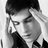

Real Disgust:


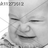

Fake Neutral:


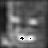

Fake Disgust:


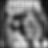


Batch number 1
Real Neutral:


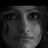

Real Disgust:


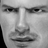

Fake Neutral:


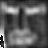

Fake Disgust:


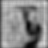


Batch number 2
Real Neutral:


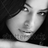

Real Disgust:


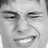

Fake Neutral:


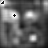

Fake Disgust:


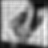


Batch number 3
Real Neutral:


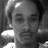

Real Disgust:


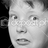

Fake Neutral:


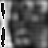

Fake Disgust:


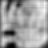


Batch number 4
Real Neutral:


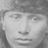

Real Disgust:


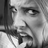

Fake Neutral:


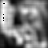

Fake Disgust:


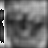


Batch number 5
Real Neutral:


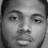

Real Disgust:


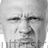

Fake Neutral:


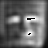

Fake Disgust:


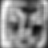


Batch number 6
Real Neutral:


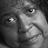

Real Disgust:


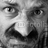

Fake Neutral:


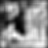

Fake Disgust:


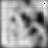


Batch number 7
Real Neutral:


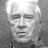

Real Disgust:


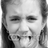

Fake Neutral:


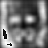

Fake Disgust:


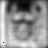


Batch number 8
Real Neutral:


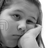

Real Disgust:


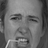

Fake Neutral:


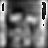

Fake Disgust:


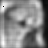


Batch number 9
Real Neutral:


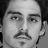

Real Disgust:


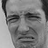

Fake Neutral:


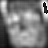

Fake Disgust:


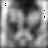


Batch number 10
Real Neutral:


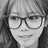

Real Disgust:


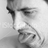

Fake Neutral:


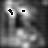

Fake Disgust:


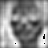


Batch number 11
Real Neutral:


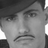

Real Disgust:


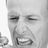

Fake Neutral:


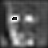

Fake Disgust:


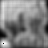


Batch number 12
Real Neutral:


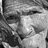

Real Disgust:


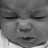

Fake Neutral:


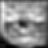

Fake Disgust:


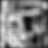


Batch number 13
Real Neutral:


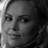

Real Disgust:


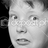

Fake Neutral:


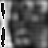

Fake Disgust:


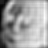


Batch number 14
Real Neutral:


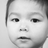

Real Disgust:


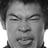

Fake Neutral:


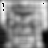

Fake Disgust:


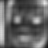


Batch number 15
Real Neutral:


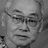

Real Disgust:


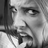

Fake Neutral:


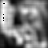

Fake Disgust:


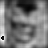


Batch number 16
Real Neutral:


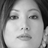

Real Disgust:


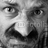

KeyboardInterrupt: ignored

In [ ]:
###### Definition of variables ######

###### Definition of variables ######
GEN_A2B_PATH = "G_A2B/" # Where the reference -> target model checkpoints are saved
GEN_B2A_PATH = "G_B2A/" # Where the target -> reference model checkpoints are saved

REFERENCE_CLASS = "Neutral"
TARGET_CLASS = "Disgust"

# Hyperparameters
BATCH_SIZE = 1 
IMAGE_SIZE = 48
INPUT_CHANNELS = 1
OUTPUT_CHANNELS = 1

EXPERIMENT_VERSION = "0.13" # version of model to use for image generation
LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

USE_CUDA = True
num_workers = multiprocessing.cpu_count()
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")

# Networks
netG_A2B = Generator(INPUT_CHANNELS, OUTPUT_CHANNELS).to(device)
netG_B2A = Generator(OUTPUT_CHANNELS, INPUT_CHANNELS).to(device)

# Load state dicts
start_epoch = min([netG_A2B.load_last_model(LOG_PATH + GEN_A2B_PATH),
                  netG_B2A.load_last_model(LOG_PATH + GEN_B2A_PATH)])
print("model version:", start_epoch)
TEST_PATH = LOG_PATH + "test_images_" + str(start_epoch) + "/"

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
input_A = torch.Tensor(BATCH_SIZE, INPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)
input_B = torch.Tensor(BATCH_SIZE, OUTPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)

# Dataset loader
transforms_ = None
testloader = DataLoader(FER2013(classA=REFERENCE_CLASS, classB=TARGET_CLASS, split='PrivateTest', transforms_=transforms_, unaligned=True), batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
###################################

# Create output folders if they don't exist
if not os.path.exists(TEST_PATH):
    os.makedirs(TEST_PATH)

with torch.no_grad():
  for batch_idx, batch in enumerate(testloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output 
    fake_B = netG_A2B(real_A).data
    fake_A = netG_B2A(real_B).data

    print("\nBatch number", batch_idx)
    _save_and_display_image(real_A[0][0].cpu(), "Real " + REFERENCE_CLASS, TEST_PATH, '%03d_real_%s.png' % (batch_idx, REFERENCE_CLASS))
    _save_and_display_image(real_B[0][0].cpu(), "Real " + TARGET_CLASS, TEST_PATH, '%03d_real_%s.png' % (batch_idx, TARGET_CLASS))
    _save_and_display_image(fake_A[0][0].cpu(), "Fake " + REFERENCE_CLASS, TEST_PATH, '%03d_fake_%s.png' % (batch_idx, REFERENCE_CLASS))
    _save_and_display_image(fake_B[0][0].cpu(), "Fake " + TARGET_CLASS, TEST_PATH, '%03d_fake_%s.png' % (batch_idx, TARGET_CLASS))


# Generating images

Run the next code block to generate images and save them to a `.npy` file. These images are saved in the same format as the FER2013 dataset, so that they can be used to augment the data during training. Make sure that the reference class, target class, and hyperparameters are consistent with the ones you used on the trained CycleGAN model you're testing. Change which model you're using by changing `EXPERIMENT_VERSION`.

The `.npy` file will be saved at `OUTPUT_PATH` so make sure you have this set to the correct location in your Drive!

In [ ]:
###### Definition of variables ######
GEN_A2B_PATH = "G_A2B/" # Where the reference -> target model checkpoints are saved
GEN_B2A_PATH = "G_B2A/" # Where the target -> reference model checkpoints are saved

REFERENCE_CLASS = "Neutral"
TARGET_CLASS = "Disgust"

# Hyperparameters
BATCH_SIZE = 1 
IMAGE_SIZE = 48
INPUT_CHANNELS = 1
OUTPUT_CHANNELS = 1

EXPERIMENT_VERSION = "0.12" # version of model to use for image generation
LOG_PATH = BASE_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

NUM_IMAGES = 10
SPLIT = "PrivateTest" # Must be either "Training", "PublicTest", or "PrivateTest"
OUTPUT_PATH = LOG_PATH

USE_CUDA = True
num_workers = multiprocessing.cpu_count()
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")

# Networks
netG_A2B = Generator(INPUT_CHANNELS, OUTPUT_CHANNELS).to(device)
netG_B2A = Generator(OUTPUT_CHANNELS, INPUT_CHANNELS).to(device)

# Load state dicts
start_epoch = min([netG_A2B.load_last_model(LOG_PATH + GEN_A2B_PATH),
                  netG_B2A.load_last_model(LOG_PATH + GEN_B2A_PATH)])
print("Using model version:", start_epoch)

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
input_A = torch.Tensor(BATCH_SIZE, INPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)
input_B = torch.Tensor(BATCH_SIZE, OUTPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE).to(device)

# Dataset loader
transforms_ = None
testloader = DataLoader(FER2013(classA=REFERENCE_CLASS, classB=TARGET_CLASS, split=SPLIT, transforms_=transforms_, unaligned=True), batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)
###################################

# Create output folders if they don't exist
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

images = []
with torch.no_grad():
  for batch_idx, batch in enumerate(testloader):
    if batch_idx < NUM_IMAGES:
      # Set model input
      real_A = Variable(input_A.copy_(batch['A']))
      real_B = Variable(input_B.copy_(batch['B']))

      # Generate output 
      fake_B = netG_A2B(real_A).data
      fake_A = netG_B2A(real_B).data

      # Save target class pixels in .npy file
      images.append(fake_B[0][0].cpu().numpy())

with open(OUTPUT_PATH + TARGET_CLASS + '_generated.npy', 'wb') as output_file:
  np.save(output_file, images)

Restoring:
model.0.weight -> 	torch.Size([64, 1, 7, 7]) = 0MB
model.0.bias -> 	torch.Size([64]) = 0MB
model.3.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
model.3.bias -> 	torch.Size([128]) = 0MB
model.6.weight -> 	torch.Size([256, 128, 3, 3]) = 1MB
model.6.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.0.weight -> 	torch.Size([256, 256, 3, 3]) = 2MB
model.9.conv_block.0.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.weight -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.running_mean -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.running_var -> 	torch.Size([256]) = 0MB
model.9.conv_block.1.num_batches_tracked -> 	torch.Size([]) = 0MB
model.9.conv_block.3.weight -> 	torch.Size([256, 256, 3, 3]) = 2MB
model.9.conv_block.3.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.4.weight -> 	torch.Size([256]) = 0MB
model.9.conv_block.4.bias -> 	torch.Size([256]) = 0MB
model.9.conv_block.4.running_mean -> 	torch.Size([256]) = 

# Testing functions 

The functions below are used for verifying the model code. While not necessary to train the model, you can use them to peek into the dataset and play with the padding values to see what sized output you get. 

In [ ]:
# Test the dataset to make sure we can iterate through the data
num_workers = multiprocessing.cpu_count()
dataloader = DataLoader(FER2013(), batch_size=100, shuffle=True, num_workers=num_workers)
for batch_idx, batch in enumerate(dataloader):
  print("Batch", batch_idx)
  display(_pixels_to_image(batch['A'][0].numpy()))

In [ ]:
### Padding calculations ###

def calculate_dims(batch_size, c_out, h_in, w_in, kernel_size, stride, padding):
  """
  Function used to calculate output dimensions at a given layer in our discriminator 
  based on the Conv2d dimension calculations in the PyTorch documentation
  
  Args:
    batch_size (int): batch size
    c_out (int): output channels
    h_in (int): input height
    w_in (int): input width
    kernel_size (int): size of kernel
    stride (int): stride for the convolution
    padding (int): amount of padding
  Returns:
    A list of [N, C, H, W] where N is the batch size, C is the number of output
    channels, H is the output height, and W is the output weight
  """
  numerator_h = h_in + 2 * padding - (kernel_size - 1) - 1
  numerator_w = w_in + 2 * padding - (kernel_size - 1) - 1
  return [batch_size, c_out, numerator_h // stride + 1, numerator_w // stride + 1]

# Sample usage of padding calculations
layers = [(64, 0), (128, 2), (256, 2), (512, 2)]
h_in = 48
w_in = 48
for idx, params in enumerate(layers):
  model_return = calculate_dims(1, params[0], h_in, w_in, 4, 2, params[1])
  print("Layer", idx + 1, "output size:", model_return[2], "x", model_return[3])
  h_in = model_return[2]
  w_in = model_return[3]
model_return = calculate_dims(1, 1, h_in, w_in, 4, 1, 0)
print("Layer", 5, "output size:", model_return[2], "x", model_return[3])  

Layer 1 output size: 23 x 23
Layer 2 output size: 12 x 12
Layer 3 output size: 7 x 7
Layer 4 output size: 4 x 4
Layer 5 output size: 1 x 1
